In [8]:
%reload_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models, transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.models import MLP, CNN2P2
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import datasets

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [9]:
preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
            transforms.Lambda(torch.flatten), # convert to vectors
        ])
trainloader, testloader = datasets.downloadMNIST(batchSize=2048, preprocess=preprocess)

In [10]:
net = MLP()
# net = CNN2P2()
net.to(DEVICE)
    
# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
# optimizer = torch.optim.Adadelta(net.parameters())
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)

# Preallocate summary variables  
iterations = 20
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
deltaWeights = []

init_weights = net.get_alignment_weights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    print('iteration: ', epoch)
    
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,batch in tqdm(enumerate(trainloader)):
        cidx = epoch*len(trainloader) + idx
        
        images, label = batch
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images, store_hidden=True)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

        # Measure Integration
        alignFull.append(net.measure_alignment(images, precomputed=True, method='alignment'))
        
        # Measure Change in Weights
        deltaWeights.append(net.compare_weights(init_weights))

    # Print statistics for each epoch
    print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))


iteration:  0


30it [00:06,  4.91it/s]


Loss in epoch   0: 0.535, Accuracy: 85.69%.
iteration:  1


30it [00:06,  4.93it/s]


Loss in epoch   1: 0.349, Accuracy: 89.47%.
iteration:  2


30it [00:06,  4.99it/s]


Loss in epoch   2: 0.293, Accuracy: 90.79%.
iteration:  3


30it [00:06,  4.98it/s]


Loss in epoch   3: 0.251, Accuracy: 92.60%.
iteration:  4


30it [00:05,  5.01it/s]


Loss in epoch   4: 0.251, Accuracy: 92.11%.
iteration:  5


30it [00:06,  4.98it/s]


Loss in epoch   5: 0.213, Accuracy: 93.91%.
iteration:  6


30it [00:05,  5.02it/s]


Loss in epoch   6: 0.196, Accuracy: 94.24%.
iteration:  7


30it [00:05,  5.03it/s]


Loss in epoch   7: 0.193, Accuracy: 94.08%.
iteration:  8


30it [00:05,  5.02it/s]


Loss in epoch   8: 0.162, Accuracy: 94.90%.
iteration:  9


30it [00:05,  5.01it/s]


Loss in epoch   9: 0.133, Accuracy: 96.22%.
iteration:  10


30it [00:05,  5.02it/s]


Loss in epoch  10: 0.207, Accuracy: 93.91%.
iteration:  11


30it [00:05,  5.01it/s]


Loss in epoch  11: 0.178, Accuracy: 94.90%.
iteration:  12


30it [00:05,  5.02it/s]


Loss in epoch  12: 0.200, Accuracy: 93.59%.
iteration:  13


30it [00:05,  5.02it/s]


Loss in epoch  13: 0.176, Accuracy: 95.23%.
iteration:  14


30it [00:06,  4.99it/s]


Loss in epoch  14: 0.180, Accuracy: 93.75%.
iteration:  15


30it [00:05,  5.00it/s]


Loss in epoch  15: 0.155, Accuracy: 95.07%.
iteration:  16


30it [00:05,  5.02it/s]


Loss in epoch  16: 0.155, Accuracy: 95.56%.
iteration:  17


30it [00:05,  5.05it/s]


Loss in epoch  17: 0.139, Accuracy: 95.23%.
iteration:  18


30it [00:05,  5.07it/s]


Loss in epoch  18: 0.130, Accuracy: 94.41%.
iteration:  19


30it [00:05,  5.07it/s]

Loss in epoch  19: 0.150, Accuracy: 94.74%.


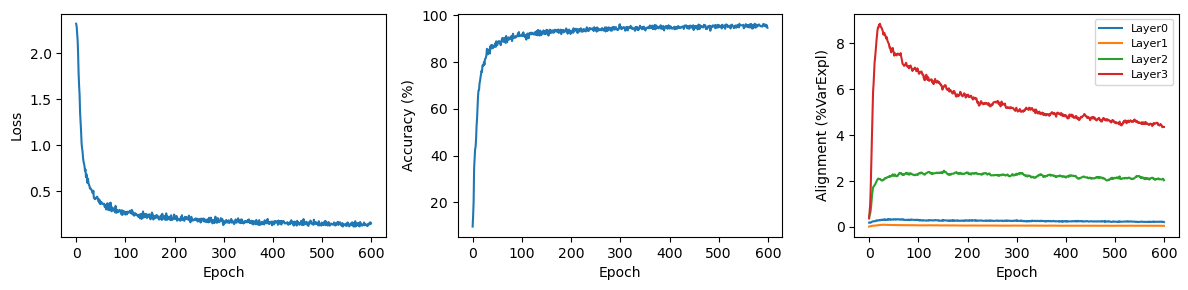

In [11]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = trackLoss.shape[0]
alignMean = utils.avg_from_full(alignFull)

# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(trackLoss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(trackAccuracy)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment (%VarExpl)')
ax[2].legend(fontsize=8, loc='upper right')

plt.tight_layout()

In [8]:
# TODO
# 1. Write more models (rewrite convolutional and AlexNet into AlignmentModels)
# 1.1. include additional AlignmentModel methods stored in extra class in base model
# 2. Make datasets a class
# 3. Make training a nice method
# 4. Rewrite existing analysis pipelines